In [1]:
from itertools import permutations
import numpy as np
from pytest import approx
import matplotlib.pyplot as plt

factorial = np.math.factorial

f = lambda x: 1 if sum(x) > 0 else 0

m = 8

subsets = np.zeros((2**m, m), dtype=int)
i = 0
for c in np.arange(0, m+1):
    s = np.zeros(m, dtype=np.bool)
    s[:c] = 1
    for p in set(permutations(s)):
        subsets[i] = np.array(p)
        i += 1
assert i == 2**m
# print(subsets)

features = np.eye(m, dtype=int)

d = 2
hshap_subsets = np.zeros((2**d, d), dtype=int)
i = 0
for c in np.arange(0, d+1):
    s = np.zeros(d, dtype=np.bool)
    s[:c] = 1
    for p in set(permutations(s)):
        hshap_subsets[i] = np.array(p)
        i += 1
assert i == 2**d
# print(hshap_subsets)

hshap_features = np.eye(d, dtype=int)

def shap(feature, x):
    feature_id = np.where(feature == 1)[0][0]
    _set_id = np.where(subsets[:, feature_id] == 0)[0]
    _set = subsets[_set_id]
    phi = sum([factorial(sum(s)) * factorial(m - sum(s) - 1)/factorial(m) * (f(x * (s + feature)) - f(x * s)) for s in _set])
    return phi

class Node:
    def __init__(self, path=np.array([[1, 1]]), stop_l=0, shap_value=0):
        self.path = path
        self.stop_l = stop_l
        self.leaf = True if len(self.path) == int(np.log(m)/np.log(2) + 1 - stop_l) else False
        self.shap_value = shap_value
    
    def children(self, x):
        _children = []
        if self.leaf == False:
            for feature in hshap_features:
                feature_id = np.where(feature == 1)[0][0]
                _set_id = np.where(hshap_subsets[:, feature_id] == 0)[0]
                _set = hshap_subsets[_set_id]
                phi = 0
                for s in _set:
                    sUi = s + feature
                    _s = np.concatenate((self.path, np.expand_dims(s, axis=0)), axis=0)
                    _sUi = np.concatenate((self.path, np.expand_dims(sUi, axis=0)), axis=0)
                    phi += factorial(sum(s)) * factorial(d - sum(s) - 1) / factorial(d) * (f(mask(_sUi, x) * x) - f(mask(_s, x) * x))
                if phi > 0:
                    feature_path = np.concatenate((self.path, np.expand_dims(feature, axis=0)), axis=0)
                    _children.append(Node(path=feature_path, stop_l=self.stop_l, shap_value=self.shap_value * phi))
        return _children

def mask(path, x):
    _x = np.ones(x.shape)
    if len(path) == 0:
        return _x
    else:
        left = 0
        right = _x.size
        for level in path:
            if sum(level) == 0:
                _x[left:right] = 0
            elif sum(level) == 1:
                mid = int((right + left)/2)
                split_id = np.where(level == 1)[0][0]
                if split_id == 0:
                    _x[mid:right] = 0
                    right = mid
                elif split_id == 1:
                    _x[left:mid] = 0
                    left = mid
        return _x

def hshap(x, stop_l=0):
    if f(x) == 0:
        return ([], 0)
    else:
        n_nodes = 0
        root_node = Node(shap_value=f(x), stop_l=stop_l)
        if root_node.leaf == True:
            leafs = [root_node]
        else:
            leafs = []
            level = root_node.children(x)
            n_nodes += len(level)
            while len(level) > 0:
                next_level = []
                for node in level:
                    if node.leaf == True:
                        leafs.append(node)
                    else:
                        _children = node.children(x)
                        for child_node in _children:
                            if child_node.leaf == True:
                                leafs.append(child_node)
                            else:
                                next_level.append(child_node)
                                n_nodes += 1
                level = next_level
        return (leafs, n_nodes)

In [2]:
from scipy.spatial import distance

m = 64
l = [0, 1, 2, 3, 4, 5, 6]
rhos = np.linspace(0, 1, 50)
reps = 100

_dict = []
for i, rho in enumerate(rhos):
    for stop_l in l:
        for j in range(reps):
            x = np.random.binomial(1, rho, size=(m))
            exact_explanation = x / sum(x) if sum(x) > 0 else np.zeros(x.size)
            (leafs, n_nodes) = hshap(x, stop_l=stop_l)
            hshap_explanation = np.zeros(x.size)
            for leaf in leafs:
                hshap_explanation += mask(leaf.path, x)
            N = sum(hshap_explanation)
            hshap_explanation = np.around(hshap_explanation/N, decimals=4) if N > 0 else hshap_explanation
            sim = 1 - distance.cosine(exact_explanation, hshap_explanation)
            _dict.append({"l": stop_l, "n_nodes": n_nodes, "sim": sim})
            print(f"rho = {rho}, k = {sum(x)}, l = {stop_l}, sim = {sim}")

0000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 3, sim = 1.0000000000000002
rho = 1.0, k = 64, l = 

In [11]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(_dict)
df.to_csv("df.csv")

sns.set_theme()
sns.set_context("paper")

sns.kdeplot(df=df, x="sim", y="n_nodes", hue="l")

ValueError: Could not interpret value `sim` for parameter `x`

x = [1 0 0 0 0 0 0 0], ds = [0.98]
x = [1 0 0 0 0 0 1 0], ds = [0.48]
x = [1 1 0 0 0 0 1 0], ds = [0.32]
x = [1 0 1 0 1 0 1 0], ds = [0.23]
x = [1 1 1 0 1 0 1 0], ds = [0.18]
x = [1 1 1 1 1 0 1 0], ds = [0.15]
x = [1 1 1 1 1 1 1 0], ds = [0.13]
x = [1 1 1 1 1 1 1 1], ds = [0.11]


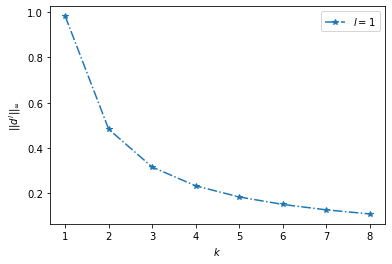

In [3]:
examples = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1]
])

out = np.zeros((len(examples), 4))

for j, x in enumerate(examples):
    exact_explanation = np.around([shap(feature, x) for feature in features], decimals=3)
    ds = []
    for stop_l in [1]:
        leafs, _ = hshap(x, stop_l=stop_l)
        # assert N == sum(exact_explanation > 0)
        hshap_explanation = np.zeros(x.size)
        for leaf in leafs:
            hshap_explanation += mask(leaf.path, x)
        N = sum(hshap_explanation)
        hshap_explanation = np.around(hshap_explanation/N, decimals=3) if N > 0 else hshap_explanation
        # assert exact_explanation == approx(hshap_explanation)
        diff = max(abs(exact_explanation - hshap_explanation))
        # diff = sum(abs(exact_explanation - hshap_explanation))
        ds.append(np.around(diff, decimals=2))
        out[j, stop_l] = diff
    print(f"x = {x}, ds = {ds}")

k = np.sum(examples, axis=1)

for stop_l in [1]:
    plt.plot(k, out[:, stop_l], "-.*", label=f"$l = {stop_l}$")
plt.xlabel("$k$")
plt.ylabel(r"$|| d^l ||_\infty$")
plt.legend()

x = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], ds = [0.5, 0.75, 0.875]
x = [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0], ds = [0.25, 0.375, 0.4375]
x = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0], ds = [0.25, 0.25, 0.2083]
x = [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0], ds = [0.125, 0.1875, 0.1875]
x = [1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0], ds = [0.125, 0.1375, 0.1375]
x = [1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0], ds = [0.1, 0.1042, 0.1042]
x = [1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0], ds = [0.1, 0.0804, 0.0804]


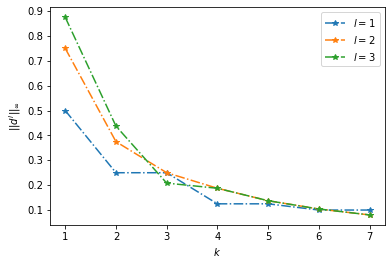

In [4]:
m = 16

examples = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

])

out = np.zeros((len(examples), 4))

for j, x in enumerate(examples):
    exact_explanation = np.around(x/sum(x), decimals=4)
    # exact_explanation = np.around([shap(feature, x) for feature in features], decimals=3)
    ds = []
    for stop_l in [1, 2, 3]:
        leafs, _ = hshap(x, stop_l=stop_l)
        # assert N == sum(exact_explanation > 0)
        hshap_explanation = np.zeros(x.size)
        for leaf in leafs:
            hshap_explanation += mask(leaf.path, x)
        N = sum(hshap_explanation)
        hshap_explanation = np.around(hshap_explanation/N, decimals=4) if N > 0 else hshap_explanation
        # assert exact_explanation == approx(hshap_explanation)
        diff = max(abs(exact_explanation - hshap_explanation))
        # diff = sum(abs(exact_explanation - hshap_explanation))
        ds.append(np.around(diff, decimals=4))
        out[j, stop_l] = diff
    print(f"x = {x}, ds = {ds}")

k = np.sum(examples, axis=1)

for stop_l in [1, 2, 3]:
    plt.plot(k, out[:, stop_l], "-.*", label=f"$l = {stop_l}$")
plt.xlabel("$k$")
plt.ylabel(r"$|| d^l ||_\infty$")
plt.legend()

In [5]:
from scipy.spatial import distance

m = 16

examples = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])

out = np.zeros((len(examples), 5))

for j, x in enumerate(examples):
    exact_explanation = np.around(x/sum(x), decimals=4)
    # exact_explanation = np.around([shap(feature, x) for feature in features], decimals=3)
    sims = []
    for stop_l in [0, 1, 2, 3, 4]:
        leafs = hshap(x, stop_l=stop_l)
        # assert N == sum(exact_explanation > 0)
        hshap_explanation = np.zeros(x.size)
        for leaf in leafs:
            hshap_explanation += mask(leaf.path, x)
        N = sum(hshap_explanation)
        hshap_explanation = np.around(hshap_explanation/N, decimals=4) if N > 0 else hshap_explanation
        # assert exact_explanation == approx(hshap_explanation)
        # diff = max(abs(exact_explanation - hshap_explanation))
        sim = 1 - distance.cosine(exact_explanation, hshap_explanation)
        # diff = sum(abs(exact_explanation - hshap_explanation))/sum(abs(exact_explanation))
        sims.append(np.around(sim, decimals=4))
        out[j, stop_l] = sim
    print(f"k = {sum(x)}, x = {x}, sim = {sims}")

k = np.sum(examples, axis=1)

for stop_l in [0, 1, 2, 3, 4]:
    plt.plot(k, out[:, stop_l], "-.*", label=f"$l = {stop_l}$")
plt.xlabel(r"$k$")
plt.ylabel(r"cosine similarity")

AttributeError: 'list' object has no attribute 'path'

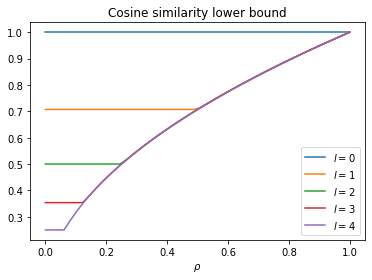

In [77]:
sim = lambda rho, l: max(2**(-l/2), rho**(1/2))

rhos = np.linspace(0, 1)
for l in [0, 1, 2, 3, 4]:
    plt.plot(rhos, [sim(rho, l) for rho in rhos], label=f"$l = %d$" % l)
plt.xlabel(r"$\rho$")
plt.title("Cosine similarity lower bound")
plt.legend()